In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2012 files belonging to 3 classes.


In [6]:
class_names= dataset.class_names

In [7]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

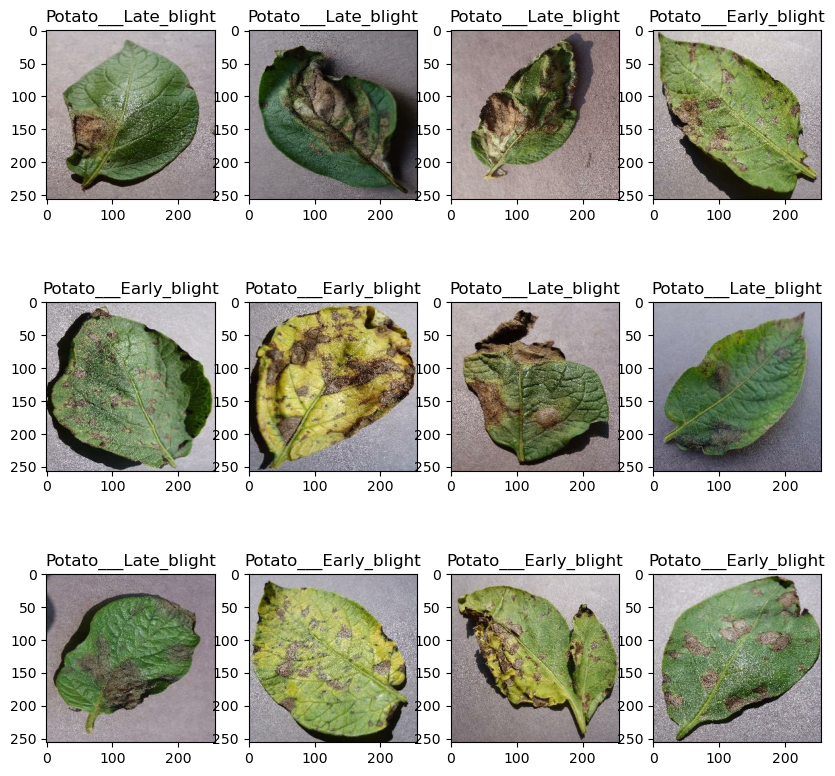

In [8]:
plt.figure(figsize=(10,10))
#we are looping through 12 images of a batch from 32 batches
for image_batch, lable_batch in dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[lable_batch[i]])
       

In [9]:
train_size=0.8
len(dataset)* train_size

50.400000000000006

In [10]:
train_ds= dataset.take(50)
test_ds= dataset.skip(50)

In [11]:
val_size=0.1

In [12]:
val_size*len(dataset)

6.300000000000001

In [13]:
val_ds=dataset.take(6)

In [14]:
test_ds=test_ds.skip(6)

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(2),
])

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)


In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [22]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [23]:
model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
50/50 [==============================] - 144s 3s/step - loss: 0.7362 - accuracy: 0.5401 - val_loss: 0.7680 - val_accuracy: 0.6302
Epoch 2/10
50/50 [==============================] - 125s 2s/step - loss: 0.5500 - accuracy: 0.7412 - val_loss: 0.4286 - val_accuracy: 0.8177
Epoch 3/10
50/50 [==============================] - 104s 2s/step - loss: 0.2559 - accuracy: 0.9073 - val_loss: 0.2139 - val_accuracy: 0.9271
Epoch 4/10
50/50 [==============================] - 97s 2s/step - loss: 0.2014 - accuracy: 0.9323 - val_loss: 0.6122 - val_accuracy: 0.7917
Epoch 5/10
50/50 [==============================] - 100s 2s/step - loss: 0.2887 - accuracy: 0.8935 - val_loss: 0.1518 - val_accuracy: 0.9479
Epoch 6/10
50/50 [==============================] - 98s 2s/step - loss: 0.0732 - accuracy: 0.9768 - val_loss: 0.0644 - val_accuracy: 0.9740
Epoch 7/10
50/50 [==============================] - 93s 2s/step - loss: 0.0865 - accuracy: 0.9687 - val_loss: 0.1575 - val_accuracy: 0.9271
Epoch 8/10
50/50

In [24]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 8s 505ms/step - loss: 0.0198 - accuracy: 0.9955


first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 748ms/step
predicted label: Potato___Early_blight


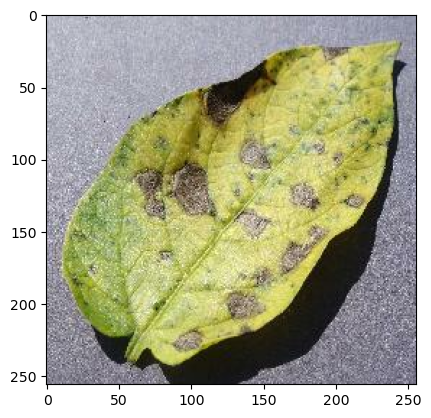

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


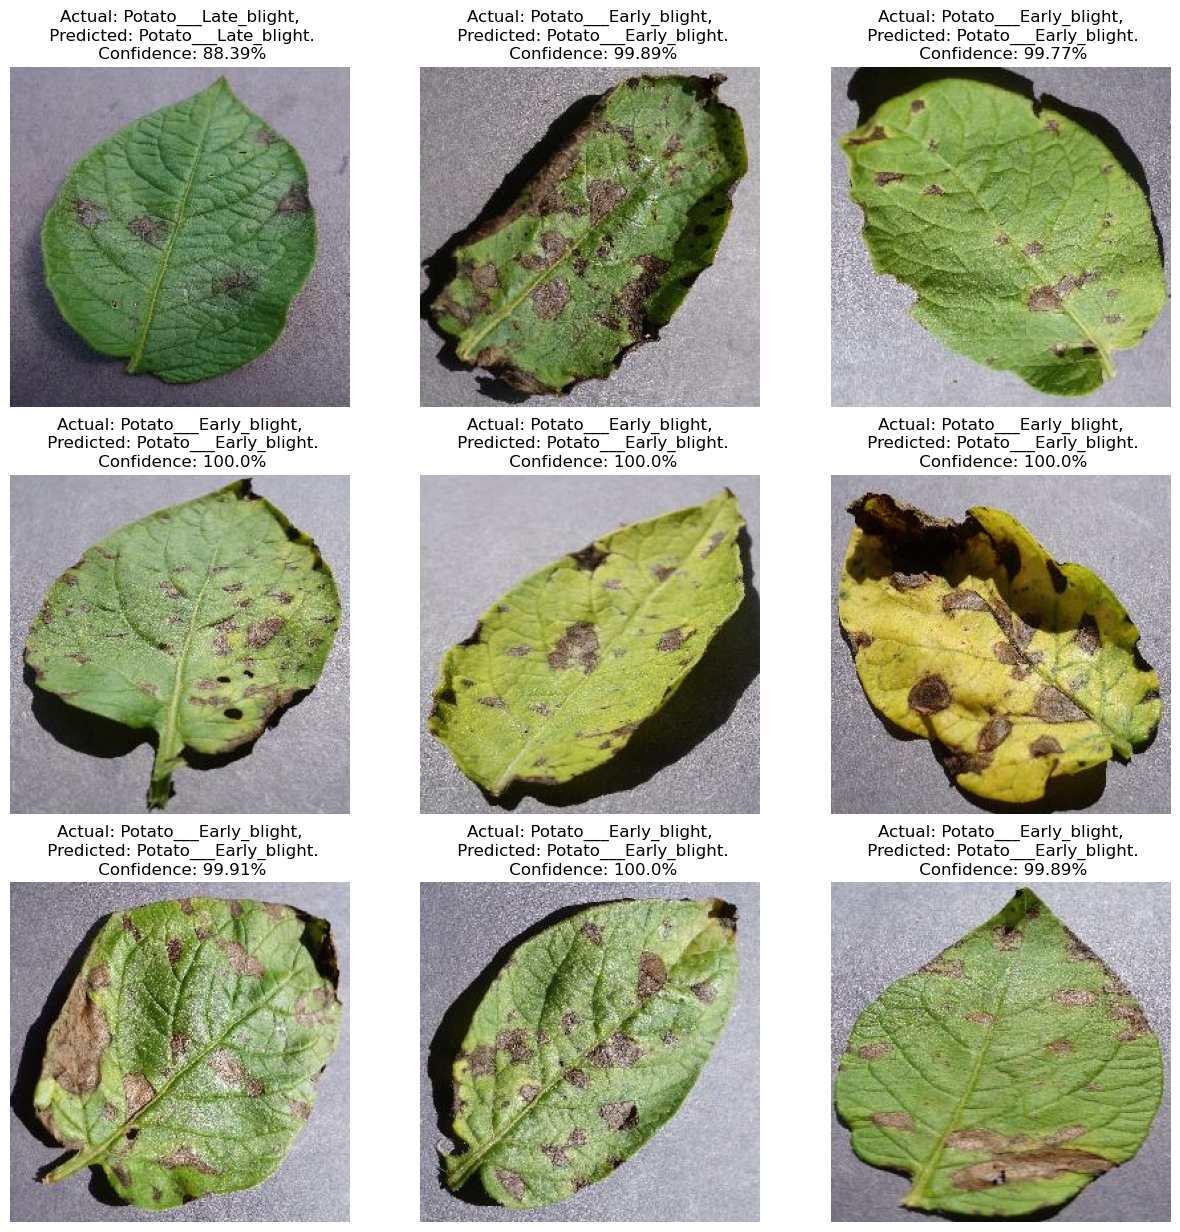

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [42]:
model.save("./potatoes.h5")